## Notebook to replicate and comment on some work by Ole Peters

By way of background, these are two YouTube videos I watched about Ole Peters' work on non-ergodic random systems.

In [23]:
from IPython.display import IFrame

IFrame('https://www.youtube.com/embed/LGqOH3sYmQA', width=560, height=315)

In [24]:
IFrame('https://www.youtube.com/embed/f1vXAHGIpfc', width=560, height=315)

Some boilerplate and load some libraries

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import math
import numpy as np
import pandas as pd

The game he describes is summarized in this screenshot:

![Game](game.png "Title")

And here is some code that captures the mechanics in Python

In [2]:
# This function defines the simple mechanics of one turn of the game, but suffers from floating-point underflow as the numbers get very small
def turn(amount: float) -> float:
    flip = random.randint(0, 1)

    if flip == 0:
        return amount * 1.5
    else:
        return amount * 0.6

# This function encodes the game using logs to avoid underflow problems
def turn_log(amount: float) -> float:
    flip = random.randint(0, 1)

    if flip == 0:
        return amount + math.log10(3) - math.log10(2)
    else:
        return amount + math.log10(3) - math.log10(5)

def game(amount, num_turns, turn_func):
    results = []
    results.append(amount)
    for i in range(num_turns):
        amount = turn_func(amount)
        results.append(amount)
        
    return results

def game_series(num_games, num_turns, turn_func):
    AMOUNT = math.log10(100)
    game_results = {}
    for i in range(num_games):
        game_results[str(i)] = game(AMOUNT, num_turns, turn_func)
        
    return pd.DataFrame(game_results)

Here we run the ensemble approach where we play the game for 60 turns, then restart 100,000 times and aggregate the results.

In [3]:
df_ensemble_log = game_series(100_000, 60, turn_log)

Here we can see some representative game traces (note the log scale)

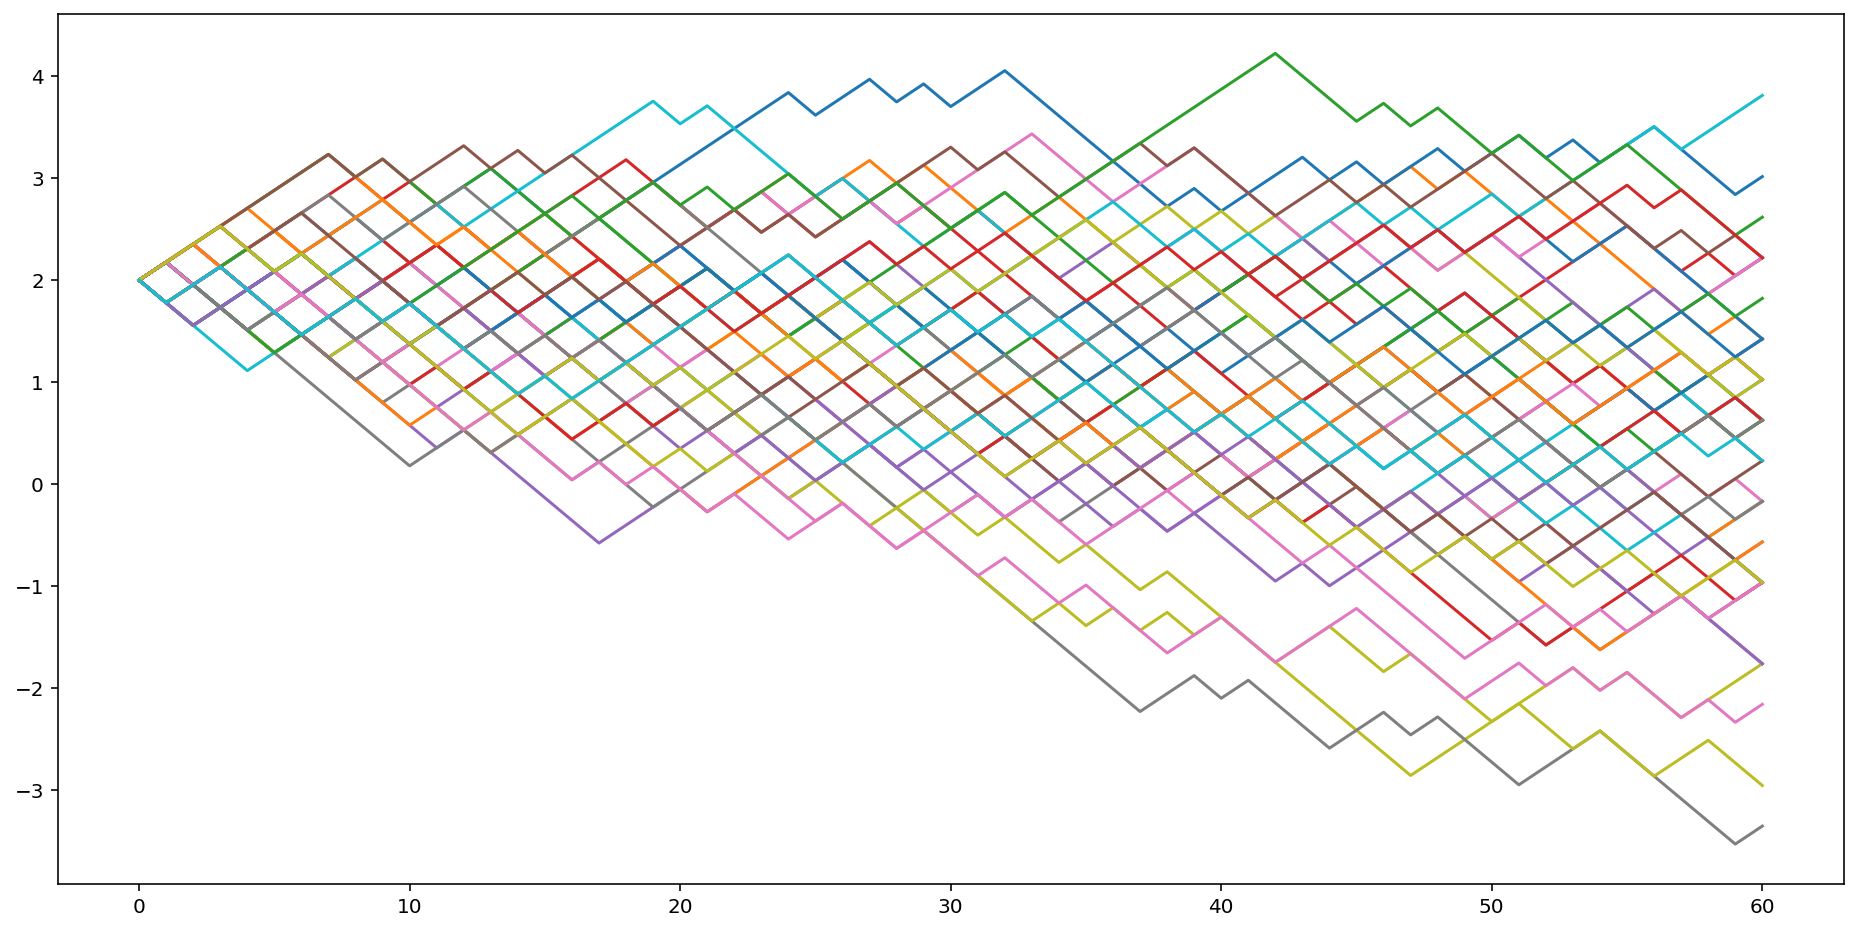

In [20]:
df_ensemble_log.iloc[:, : 50].plot(legend=None, figsize=(16,8));

Here we compute the mean (i.e. expected value in the video). But I also chose to compute the median since, unlike the mean, it is an unbiased estimator.

In [5]:
# Note we have to undo the log to compute the averages
df_ensemble = np.power(10, df_ensemble_log)

# We convert back to logs to keep the graphs consistent
df_ensemble['mean'] = np.log10(df_ensemble.mean(axis=1))
df_ensemble['median'] = np.log10(df_ensemble.median(axis=1))

Here I plot the mean/expected value and it looks similar to in the video. I'll plot the median later.

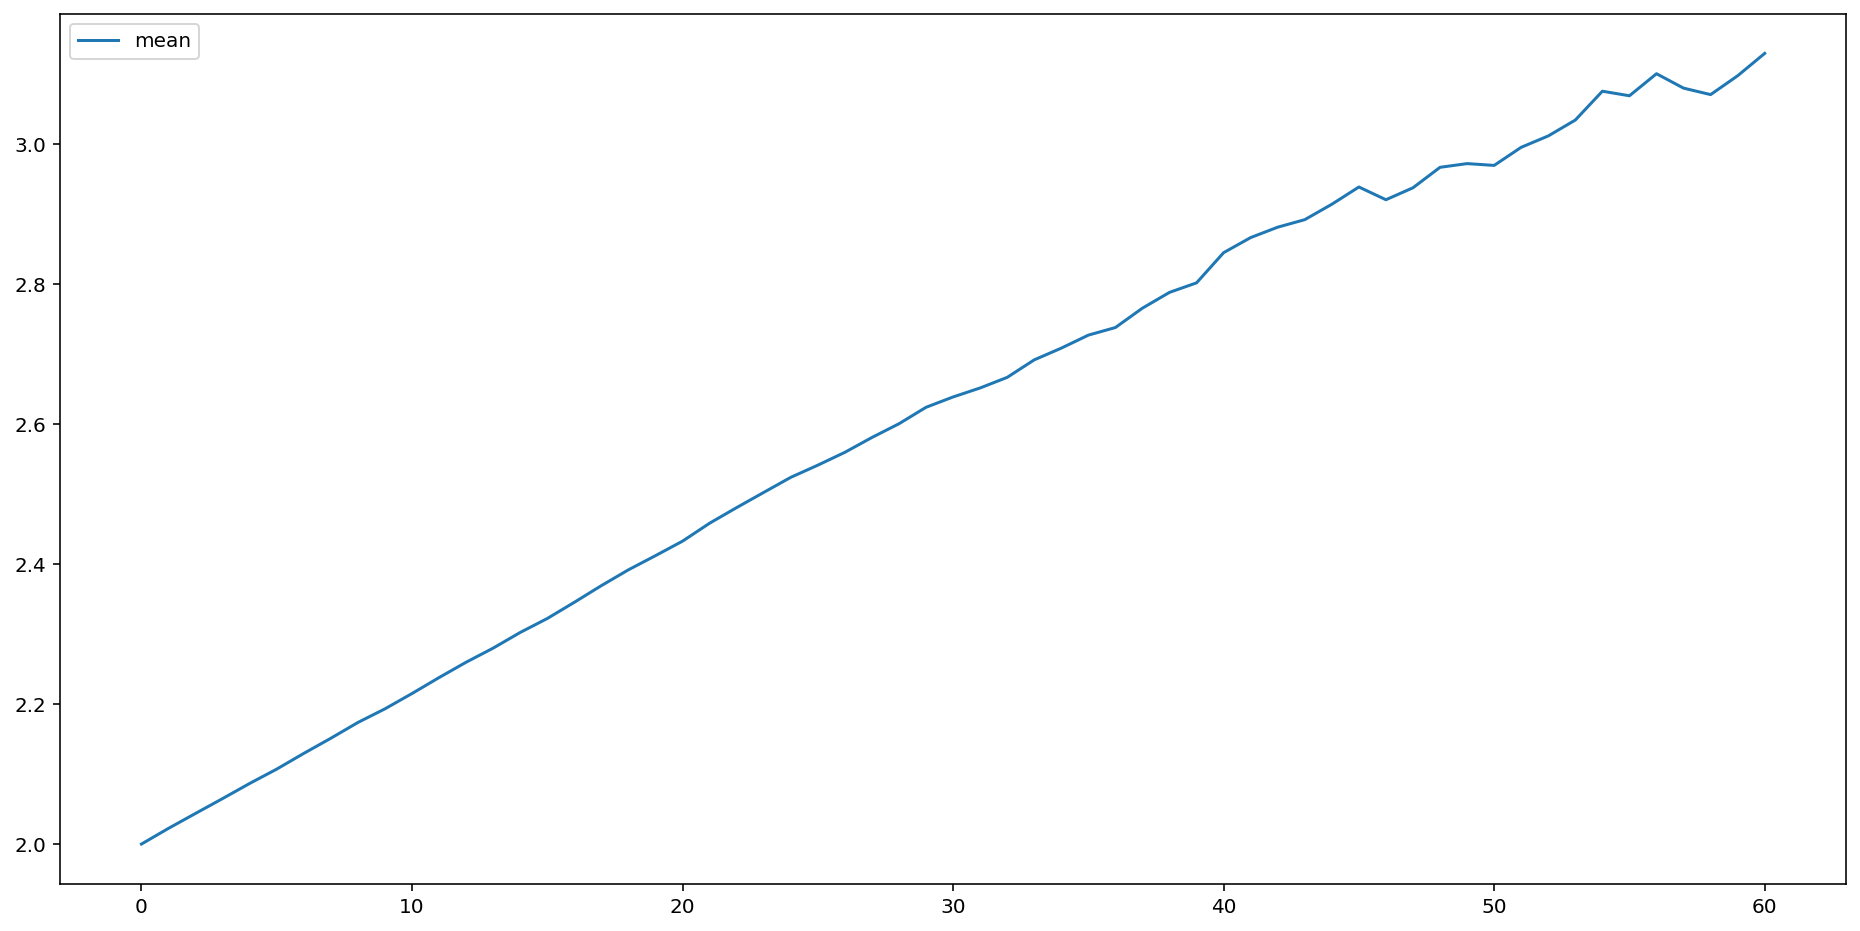

In [19]:
df_ensemble[['mean']].plot(figsize=(16,8));

Here we run the game for a year, one turn per minute and see a similar result to the video i.e. that it suggests a very different view of the game compared to the expected value approach.

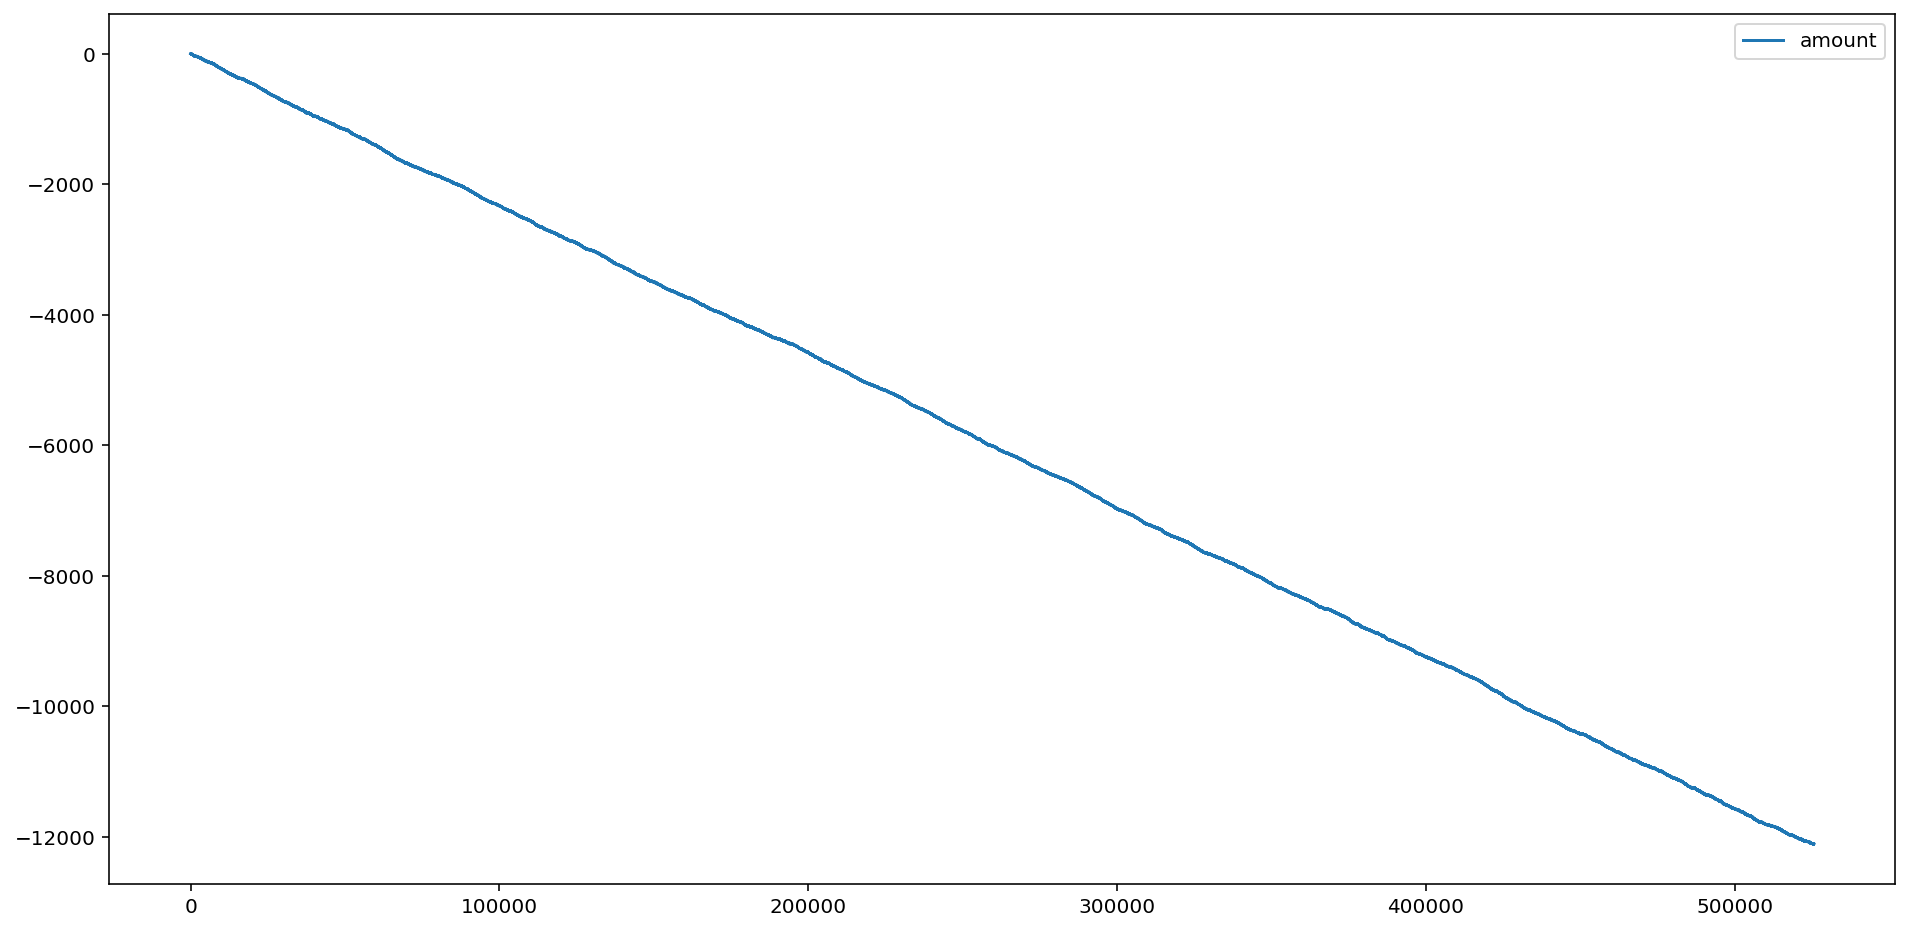

In [18]:
df_longrun = pd.DataFrame({'amount': game(math.log10(100), 60*24*365, turn_log)})
df_longrun.plot(figsize=(16,8));

So that replicates a key result in the video. But if I now plot the median it seems to agree, at least directionally, much more closely with the case where we run the game for a long time

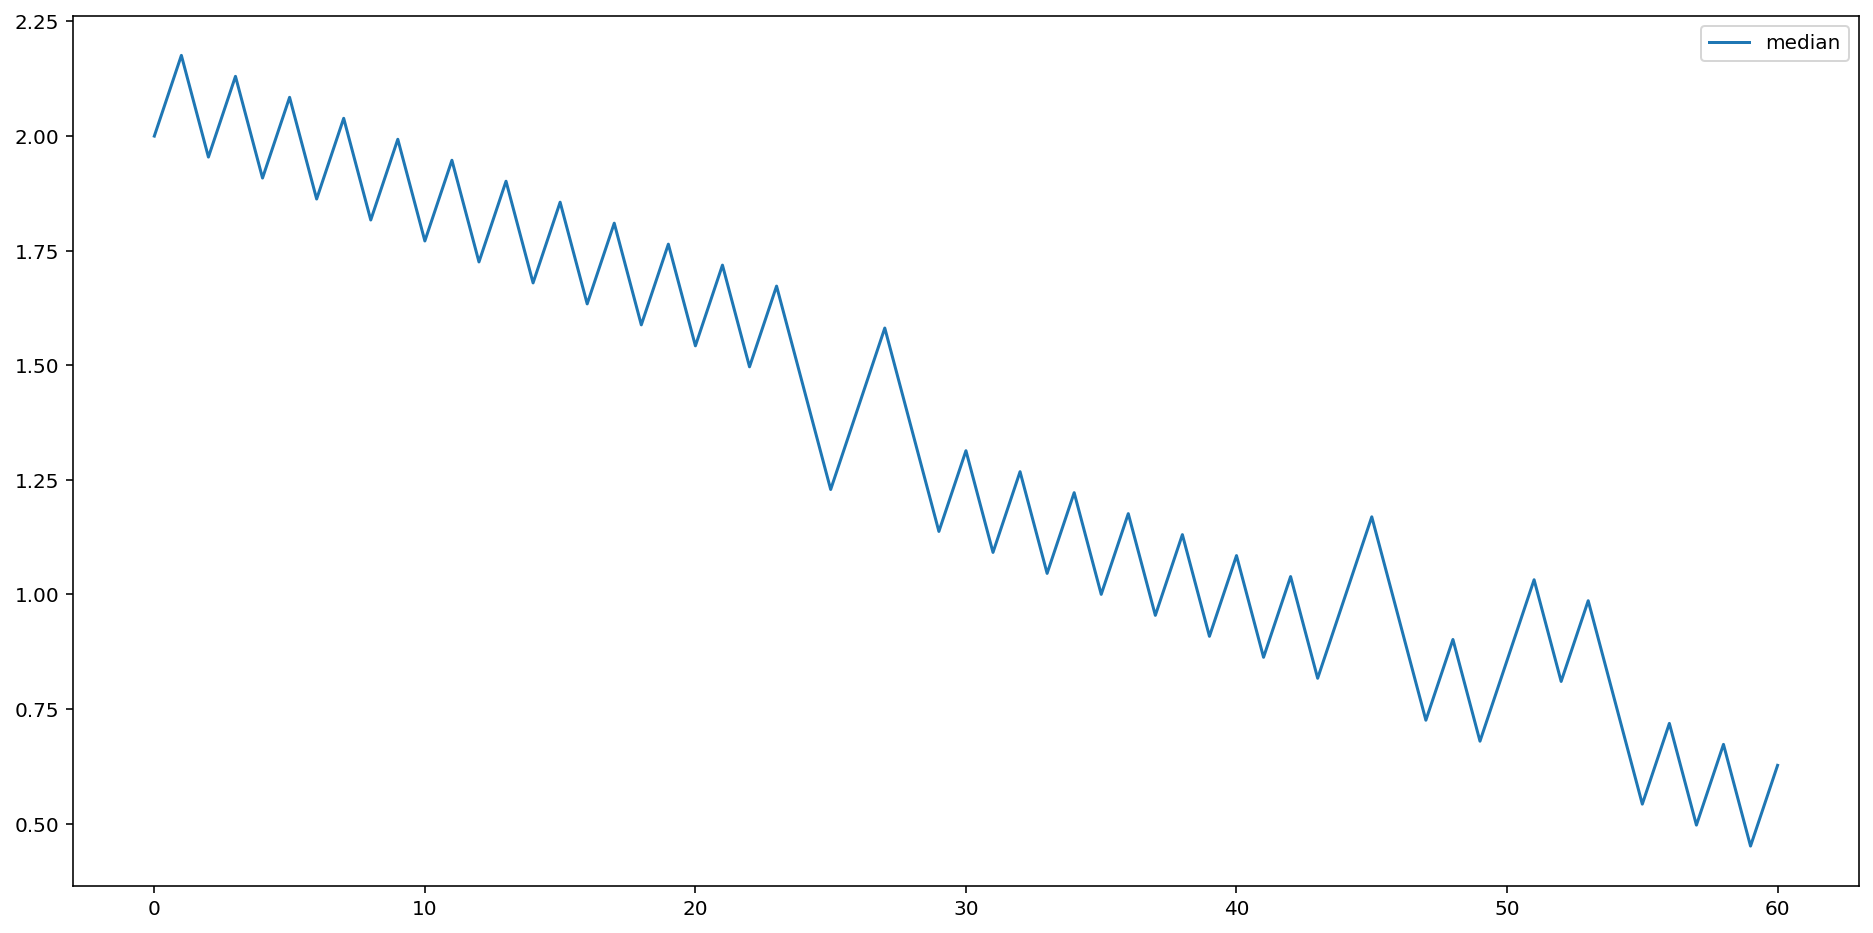

In [17]:
df_ensemble[['median']].plot(figsize=(16,8));

Now let's see what happens if we run the ensemble approach again but this time play each game much longer (1,000 turns, instead of just 60), then restart 100,000 times (as before) and aggregate the results.

In [9]:
# This can take a while to finish
df_ensemble_log_long = game_series(100_000, 1_000, turn_log)

Compute the averages as before.

In [10]:
df_ensemble_long = np.power(10, df_ensemble_log_long)

df_ensemble_long['mean'] = np.log10(df_ensemble_long.mean(axis=1))
df_ensemble_long['median'] = np.log10(df_ensemble_long.median(axis=1))

Now let's plot the mean and median together. The median now looks even more like the long-time version and the expected value/mean is apparently much less meaningful.

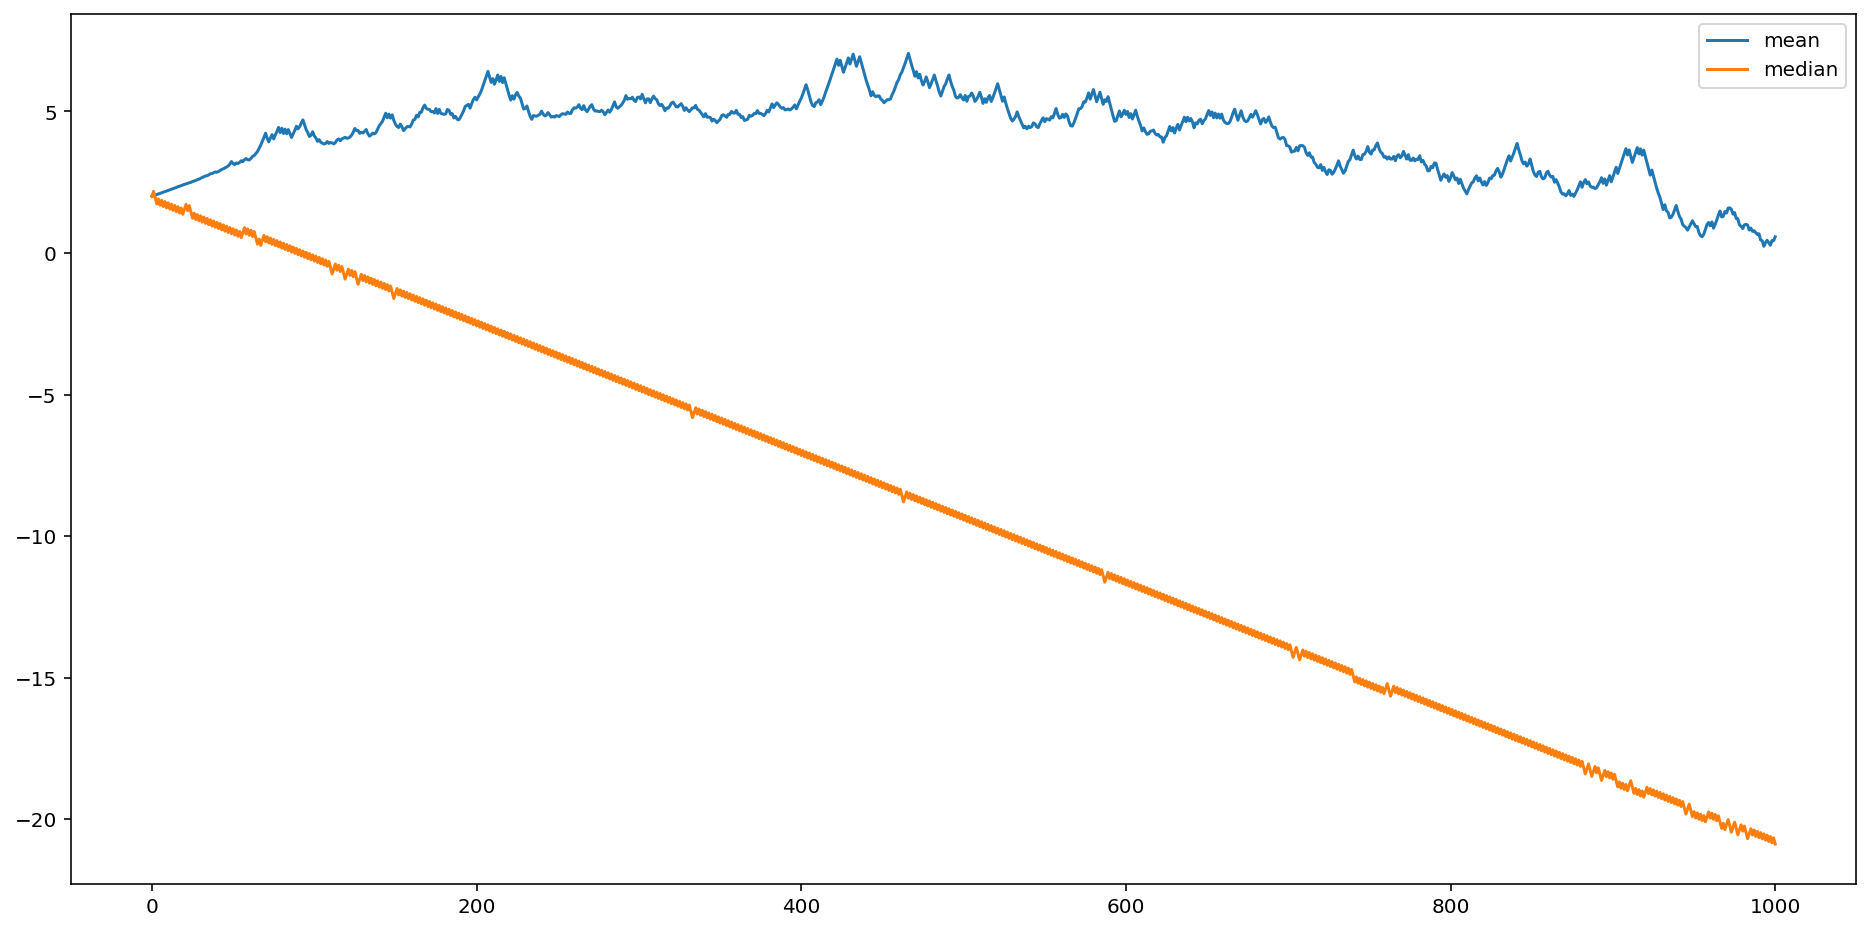

In [16]:
df_ensemble_long[['mean', 'median']].plot(figsize=(16,8));